Example Jupyter notebook for training a simple neural network to learn a sine function using JAX. This notebook uses the Equinox library for neural networks, Optax for the optimisation, PyTorch for the dataloaders, and the JIT functionality of JAX to speed up training.

This material is heavily inspired by these excellent tutorials:

[Neural Networks in Equinox (JAX DL framework) with Optax](https://www.youtube.com/watch?v=WyCDsxZb8Gs)

[Convolutional Neural Network on MNIST using Equinox](https://docs.kidger.site/equinox/examples/mnist/)

# Imports

In [1]:
import time
import jax  # https://github.com/google/jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax
import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping
from typing import List, Tuple

# NN library
import equinox as eqx # https://github.com/patrick-kidger/equinox

# Hyperparameters

In [2]:
# hyperparameters

N_SAMPLES = 200  # total number of data points
SCALE = 0.25 # noise scale for the data generation
SPLIT = 0.8 # fraction of data used for training
BATCH_SIZE = 50
LAYERS = [1, 10, 10, 1] # number of neurons in each fully-connected layer
LEARNING_RATE = 3e-4
EPOCHS = 5000
PRINT_EVERY = int(EPOCHS / 10)  # print progress during training every PRINT_EVERY epochs
SEED = 5678

key = jax.random.PRNGKey(SEED)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Generate training and test data

In [3]:
# generate data according to a sine function + noise

xs = np.random.default_rng().uniform(low=-np.pi, high=np.pi, size=(N_SAMPLES, 1))
ys = np.sin(xs) + np.random.default_rng().normal(scale=SCALE, size=(N_SAMPLES, 1))

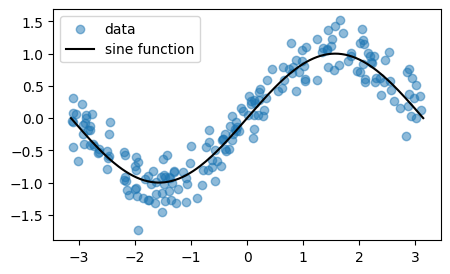

In [4]:
x_plot = np.linspace(start=-jnp.pi, stop=jnp.pi, num=N_SAMPLES)  # for plotting underlying function

fig, ax = plt.subplots(figsize=(5, 3))

ax.scatter(xs, ys, alpha=0.5, label='data')  # data
ax.plot(x_plot, np.sin(x_plot), 'k', label='sine function')  # underlying function for NN to learn
ax.legend()

plt.show()

In [5]:
# Using PyTorch dataloaders for handling the training and test data

# transform to torch tensor for dataset handling
tensor_xs = torch.Tensor(xs)
tensor_ys = torch.Tensor(ys)

# create the dataset
dataset = TensorDataset(tensor_xs, tensor_ys)

# split the dataset into train and test sets
train_set, test_set = random_split(dataset, [SPLIT, 1 - SPLIT], generator=torch.Generator().manual_seed(SEED))

# create the dataloader
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
# Check the data

dummy_x, dummy_y = next(iter(train_loader))
dummy_x, dummy_y = dummy_x.numpy(), dummy_y.numpy()

# Should have shape (BATCH_SIZE, 1)
print(dummy_x.shape)
print(dummy_y.shape)

(50, 1)
(50, 1)


# Define NN model

In [7]:
# Defining the MLP model, and inherit the eqx.Module class
class MLP(eqx.Module):
    """Multi-Layer Perceptron (MLP) neural network model."""
    
    layers: List
        
    def __init__(
        self, 
        layer_sizes, 
        key,
    ):
        """
        Initialize the MLP model.

        Args:
            layer_sizes: A list of integers representing the sizes of each layer in the MLP.
            key: The JAX random key used for initialization.
        """
        
        self.layers = []
        
        for (feat_in, feat_out) in zip(layer_sizes[:-2], layer_sizes[1:-1]):
            key, subkey = jax.random.split(key)
            
            self.layers.append(
                eqx.nn.Linear(feat_in, feat_out, use_bias=True, key=subkey)
            )  # fully-connected layer
            self.layers.append(
                jnp.tanh
            )  # activation function
        
        key, subkey = jax.random.split(key)
        
        self.layers.append(
            eqx.nn.Linear(layer_sizes[-2], layer_sizes[-1], use_bias=True, key=subkey)
        )  # final layer
    
    # __call__ turns an instance of this class into a callable object, which behaves like a function
    def __call__(
        self, 
        x: Float[Array, "1 1"],
    ) -> Float[Array, "1 1"]:
        """
        Forward pass of the MLP model.

        Args:
            x: Input data.

        Returns:
            Output prediction.
        """
        
        # apply each layer in sequence
        for layer in self.layers:
            x = layer(x)
            
        return x

In [8]:
key, subkey = jax.random.split(key)

# create the MLP model
model = MLP(layer_sizes=LAYERS, key=subkey)

# display the model structure
print(model)

MLP(
  layers=[
    Linear(
      weight=f32[10,1],
      bias=f32[10],
      in_features=1,
      out_features=10,
      use_bias=True
    ),
    <wrapped function <lambda>>,
    Linear(
      weight=f32[10,10],
      bias=f32[10],
      in_features=10,
      out_features=10,
      use_bias=True
    ),
    <wrapped function <lambda>>,
    Linear(
      weight=f32[1,10],
      bias=f32[1],
      in_features=10,
      out_features=1,
      use_bias=True
    )
  ]
)


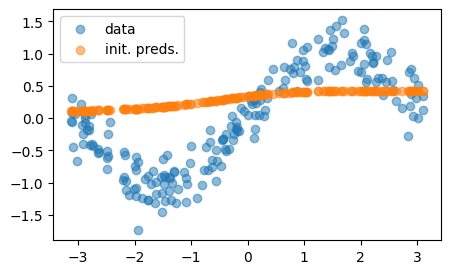

In [9]:
# Plot initial predictions on all x samples

# The dataset has the shape (N_SAMPLES, 1), but our model operations on
# a single input of shape (1, 1).
#
# Therefore, we have to use jax.vmap, which in this case maps our model over the
# leading axis of our input array, and vectorises the calculation.

# produce predictions using randomly initialised weights
initial_preds = jax.vmap(model)(xs)

# plot results
fig, ax = plt.subplots(figsize=(5, 3))

ax.scatter(xs, ys, alpha=0.5, label='data')  # data
ax.scatter(xs, initial_preds, alpha=0.5, label='init. preds.')  # initial predictions
ax.legend()

plt.show()

# Loss and model evaluation

In [10]:
def loss(
    model: MLP, 
    x: Float[Array, "batch 1"], 
    y: Float[Array, "batch 1"],
) -> Float[Array, ""]:
    """
    Compute the loss between the model predictions and the ground truth.

    Args:
        model: The MLP model used for making predictions.
        x: Input data of shape (batch_size, 1).
        y: Ground truth data of shape (batch_size, 1).

    Returns:
        The mean squared error loss between the predictions and the ground truth.
    """
    
    pred_y = jax.vmap(model)(x)
    delta = pred_y - y
    
    return jnp.mean(delta ** 2)

In [11]:
# Example loss

loss_value = loss(model, dummy_x, dummy_y)  # calculate loss on a batch of training data
print(f'loss: {loss_value}, loss shape: {loss_value.shape}') # should be scalar

# Example inference

output = jax.vmap(model)(dummy_x)
print(f'batch output shape: {output.shape}') # batch of predictions, should have shape (BATCH_SIZE, 1)

loss: 0.5942326188087463, loss shape: ()
batch output shape: (50, 1)


In [12]:
# JAX can only differentiate w.r.t. the model parameters
# so we need to filter out the parts of the model that are not
# arrays (e.g., the activation functions), for when we compute
# the gradients
loss_and_grad = eqx.filter_value_and_grad(loss)

#JIT the loss function for use in evaluate(...)
loss = eqx.filter_jit(loss)

In [13]:
# Evaluation function for test data

def evaluate(
    model: MLP, 
    test_loader: torch.utils.data.DataLoader,
) -> Float[Array, ""]:
    """
    Evaluate the model on the test data.

    Args:
        model: The MLP model.
        test_loader: PyTorch DataLoader for the test data.

    Returns:
        The average loss over the test data as a float value.
    """
    
    tot_loss = 0
    
    for x, y in test_loader:
        x, y = x.numpy(), y.numpy()
        tot_loss += loss(model, x, y)
        
    return tot_loss / len(test_loader)

In [14]:
# Example evaluation

evaluate(model, test_loader)  # avg. loss over a sample batch of training data

Array(0.33297226, dtype=float32)

# Training the model

In [15]:
# define optimiser

optim = optax.adam(LEARNING_RATE)

In [16]:
def train(
    model: MLP,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    optim: optax.GradientTransformation,
    epochs: int,
    print_every: int,
) -> MLP:
    """
    Train the MLP model.

    Args:
        model: The MLP model to be trained.
        train_loader: PyTorch DataLoader for the training data.
        test_loader: PyTorch DataLoader for the test data.
        optim: The optimizer used for training.
        epochs: Number of training epochs.
        print_every: Interval for printing progress during training.

    Returns:
        The trained MLP model.
    """
    
    # can only train the arrays in the model, so
    # filter out everything else
    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    
    # JIT the entire update step to make it FAST
    @eqx.filter_jit
    def make_step(
        model: MLP,
        opt_state: PyTree,
        x: Float[Array, "batch 1"],
        y: Float[Array, "batch 1"],
    ) -> Tuple[MLP, PyTree, Float[Array, ""]]:
        """
        Perform a single update step during training.

        Args:
            model: The MLP model.
            opt_state: The optimizer state.
            x: Input data of shape (BATCH_SIZE, 1).
            y: Ground truth labels of shape (BATCH_SIZE, 1).

        Returns:
            Updated model, optimizer state, and loss value for the current step.
        """
        
        loss_value, grads = loss_and_grad(model, x, y) # loss, grads w.r.t. model params.
        updates, opt_state = optim.update(grads, opt_state, model) # optimiser calculates the updates to model params
        model = eqx.apply_updates(model, updates) # updates applied to model
        
        return model, opt_state, loss_value
    
    # loop over epochs
    for epoch in range(epochs):
        start_time = time.time()
        epoch_loss = 0
        
        # loop over each batch, fetched from the training dataloader
        for (x, y) in train_loader:
            x, y = x.numpy(), y.numpy()
            
            # update step
            model, opt_state, train_loss = make_step(model, opt_state, x, y)
            epoch_loss += train_loss.item()
            
        avg_epoch_loss = epoch_loss / len(train_loader)
        
        epoch_time = time.time() - start_time
        
        if (epoch % print_every) == 0 or (epoch == epochs - 1):
            test_loss = evaluate(model, test_loader)  # calculate loss on test data
            print("Epoch {} in {:0.3f} sec".format(epoch + 1, epoch_time))
            print("Training set loss {}".format(train_loss.item()))
            print("Test set loss {}".format(test_loss.item()))
            
    return model

In [17]:
# train the model

model = train(model, train_loader, test_loader, optim, EPOCHS, PRINT_EVERY)

Epoch 0 in 0.442 sec
Training set loss 0.6474624276161194
Test set loss 0.32436439394950867
Epoch 500 in 0.002 sec
Training set loss 0.24162718653678894
Test set loss 0.08082256466150284
Epoch 1000 in 0.003 sec
Training set loss 0.10274118185043335
Test set loss 0.05364121496677399
Epoch 1500 in 0.002 sec
Training set loss 0.062062978744506836
Test set loss 0.04457555711269379
Epoch 2000 in 0.002 sec
Training set loss 0.11366727203130722
Test set loss 0.04202556237578392
Epoch 2500 in 0.002 sec
Training set loss 0.05899128317832947
Test set loss 0.04284350201487541
Epoch 3000 in 0.002 sec
Training set loss 0.06368426978588104
Test set loss 0.04297838360071182
Epoch 3500 in 0.002 sec
Training set loss 0.09642171859741211
Test set loss 0.04438187554478645
Epoch 4000 in 0.002 sec
Training set loss 0.07089527696371078
Test set loss 0.042378395795822144
Epoch 4500 in 0.003 sec
Training set loss 0.04511259123682976
Test set loss 0.041969526559114456
Epoch 4999 in 0.002 sec
Training set loss 

# Model output

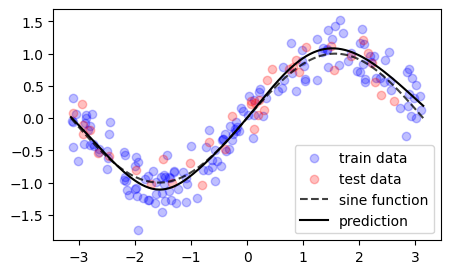

In [18]:
train_x, train_y = train_set[:]
test_x, test_y = test_set[:]

train_x, train_y = train_x.numpy(), train_y.numpy()
test_x, test_y = test_x.numpy(), test_y.numpy()

# plot the result

fig, ax = plt.subplots(figsize=(5, 3))

ax.scatter(train_x, train_y, c='b', alpha=0.25, label='train data')
ax.scatter(test_x, test_y, c='r', alpha=0.25, label='test data')
ax.plot(x_plot, np.sin(x_plot), 'k--', alpha=0.75, label='sine function')
ax.plot(x_plot, jax.vmap(model)(np.expand_dims(x_plot, 1)), c='k', label='prediction')
ax.legend()

plt.show()